<h1>Содержание<span class="tocSkip"></span></h1>
</font></a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-изучение-данных" data-toc-modified-id="Загрузка-и-изучение-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и изучение данных</a></span></li><li><span><a href="#Формирование-выборок" data-toc-modified-id="Формирование-выборок-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Формирование выборок</a></span><ul class="toc-item"><li><span><a href="#Разбиение-данных-на-выборки" data-toc-modified-id="Разбиение-данных-на-выборки-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Разбиение данных на выборки</a></span></li><li><span><a href="#Очистка-и-токенизация" data-toc-modified-id="Очистка-и-токенизация-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Очистка и токенизация</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#TF-IDF-для-корпуса-текстов" data-toc-modified-id="TF-IDF-для-корпуса-текстов-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>TF-IDF для корпуса текстов</a></span></li></ul></li></ul></li><li><span><a href="#Обучение-и-анализ-моделей" data-toc-modified-id="Обучение-и-анализ-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и анализ моделей</a></span><ul class="toc-item"><li><span><a href="#Модель-логистической-регрессии" data-toc-modified-id="Модель-логистической-регрессии-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель логистической регрессии</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Выбор-и-проверка-лучшей-модели" data-toc-modified-id="Выбор-и-проверка-лучшей-модели-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Выбор и проверка лучшей модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

В рамках проекта необходимо построить модель для задачи классификации.

Интернет-магазин «Викишоп» запускает новый сервис, в рамках которого пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужна модель для поиска токсичных комментариев, чтобы отправлять их на модерацию. 

Модель должна классифицировать комментарии на позитивные и негативные. Для построения модели используется набор данных с разметкой о токсичности правок.

Значение метрики *F1* должно быть не меньше 0.75. 

Этапы решения задачи:

1. Загрузка и подготовка данных.
2. Анализ данных.
3. Обучение и анализ моделей.
4. Выбор наилучшей модели и проверка ее качества на тестовой выборке.

## Предобработка данных

### Загрузка и изучение данных

Импортирт библиотек:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import catboost as cb
import lightgbm as lgb
import nltk
import re
import seaborn as sb

from joblib import dump, load
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from numpy.random import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error,f1_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from tqdm import notebook

In [2]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Чтение файла:

In [3]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    print('Ошибка!')

Целевой признак находится в столбце `'toxic'`.

Выведем основную информацию о данных методом `info()`.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


В таблице 159 292 строк, 3 столбца. Пропусков нет.

Выведем первые 5 строк таблицы.

In [5]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Столбец `'text'` содержит текст комментария. Столбец `'Unnamed: 0'` дублирует номера строк, его можно удалить.

In [6]:
data = data.drop(columns = ['Unnamed: 0'])

Проверим данные на наличие дубликатов.

In [7]:
data.duplicated().sum()

0

Дубликатов нет.

Выведем основные характеристики данных.

In [8]:
data.describe()

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Значения в целевом столбце адекватные. Среднее значение близко к нулю, это может свидетельствовать о дисбалансе классов.

Выведем количество токсичных и нейтральных комментариев.

In [9]:
data.groupby('toxic')['text'].count()

toxic
0    143106
1     16186
Name: text, dtype: int64

Построим столбчатую диаграмму с количеством комментариев, определенных как токсичные или нет.

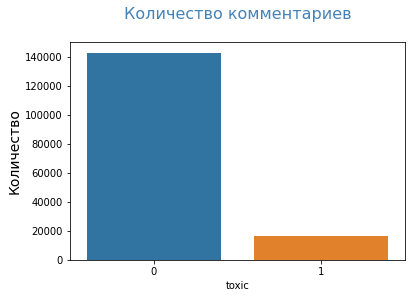

In [10]:
sb.barplot(x = data.groupby('toxic')['text'].count().index,
           y = data.groupby('toxic')['text'].count())

plt.title('Количество комментариев\n',
          fontsize = 16, 
          color = 'SteelBlue')

plt.ylabel('Количество',
          fontsize = 14)

plt.show()

Наблюдается дисбаланс классов.

### Формирование выборок

#### Разбиение данных на выборки

Отделим признаки и целевой признак.

In [11]:
features = data['text']
target = data['toxic']

Обучающая, валидационная и тестовая выборки будут относиться как 8:1:1, так как данных очень много. Сформируем тестовую выборку. Для этого зафиксируем параметр `random_state`.

In [12]:
state = np.random.RandomState(12345)

В данных есть дисбаланс классов, поэтому нужно использовать стратифицированные выборки. Для этого функции `train_test_split()` передадим гиперпараметр `stratify = target`.

In [13]:
features_train_valid,features_test,target_train_valid,target_test = train_test_split(features,
                                                                                     target,
                                                                                     test_size=0.1,
                                                                                     random_state=state,
                                                                                     stratify=target)

Сформируем обучающую и валидационную выборки.

In [14]:
features_train,features_valid,target_train,target_valid = train_test_split(features_train_valid,
                                                                           target_train_valid,
                                                                           test_size=0.11,
                                                                           random_state=state,
                                                                           stratify=target_train_valid)

#### Очистка и токенизация

Удалим из текстов слова, которые содержат какие-либо символы, кроме буквенных. Напишем функцию для очистки одного текста от таких слов, в которой заменим их одним пробелом с помощью функциии `re.sub()`, приведем тексты к нижнему регистру методом `lower()` и преобразуем в списки методом `split()`.

In [15]:
def clear_text(text):
    return re.sub(r'[^a-zA-Z]',' ',text).lower().split()

Применим функцию к каждому тексту валидационной выборки.

In [16]:
%%time

features_valid_clean = features_valid.apply(lambda x: clear_text(x))

CPU times: user 377 ms, sys: 43.1 ms, total: 420 ms
Wall time: 423 ms


Проверим результат очистки.

In [17]:
features_valid_clean.head()

63922     [christopher, richard, barker, what, is, your,...
87079      [i, thought, he, looked, like, pee, wee, herman]
134449    [nipple, nipple, nipple, nipple, nipple, nippl...
133547    [mcdonalds, them, selves, do, not, target, the...
92694     [capitalization, you, are, misspelling, the, w...
Name: text, dtype: object

Проведем очистку тестовой и обучающей выборок.

#### Лемматизация

Проведем лемматизацию слов, то есть приведем слова к начальной форме — лемме. Воспользуемся классом `WordNetLemmatizer()`. Для корректной лемматизации ему необходимо передавать вместе со словом его часть речи. Напишем функцию для поиска части речи, внутри которой функция `pos_tag()` возвращает форму части речи, где первая буква определяет часть речи. Написанная функция возвращает соответствующий ей тег для `wordnet`.

Функция ниже лемматизирует список слов с помощью `WordNetLemmatizer()`, используя тег с частью речи слова из функции `get_wordnet_pos()`.

Применим функцию `get_wordnet_pos()` для лемматизации всех текстов валидационной выборки.

Лемматизация занимает 1 мин 53 c.

Сохраним полученный датафрейм с лемматизированной валидационной выборкой в файл `'features_valid_lemmatized_toxic_comments.csv'`.

Аналогично лемматизируем и сохраним тестовую и обучающую выборки.

Лемматизация занимает 1 мин 49 c.

Лемматизация занимает 15 мин 8 c.

Загрузим лемматизированные выборки.

In [18]:
features_valid_lemmatized = pd.read_csv('features_valid_lemmatized_toxic_comments.csv')['text']

После очистки текстов могли появиться пропуски. Найдем количество пропусков.

In [19]:
features_valid_lemmatized.isna().sum()

1

Удалим объекты из целевого признака и пропуски из признаков.

In [20]:
target_valid = (target_valid.reset_index(drop = True)
                            .drop(index = features_valid_lemmatized[features_valid_lemmatized.isna()].index.to_list()))

In [21]:
features_valid_lemmatized = features_valid_lemmatized.dropna()

Создадим из выборки массив - корпус текстов.

In [22]:
corpus_valid = features_valid_lemmatized.values

Проверим корректность лемматизации.

In [23]:
features_valid_lemmatized.head()

0    christopher richard barker what be your proble...
1                i thought he look like pee wee herman
2    nipple nipple nipple nipple nipple nipple nipp...
3    mcdonalds them self do not target the food at ...
4    capitalization you be misspell the word idiot ...
Name: text, dtype: object

Лемматизация проведена корректно.

Аналогично обработаем тестовую и обучающую выборки.

In [24]:
features_test_lemmatized = pd.read_csv('features_test_lemmatized_toxic_comments.csv')['text']

Найдем количество пропусков.

In [25]:
features_test_lemmatized.isna().sum()

1

Удалим объекты из целевого признака и пропуски из признаков.

In [26]:
target_test = (target_test.reset_index(drop = True)
                          .drop(index = features_test_lemmatized[features_test_lemmatized.isna()].index.to_list()))

In [27]:
features_test_lemmatized = features_test_lemmatized.dropna()

Создадим из выборки массив - корпус текстов.

In [28]:
corpus_test = features_test_lemmatized.values

Загрузим обучающую выборку.

In [29]:
features_train_lemmatized = pd.read_csv('features_train_lemmatized_toxic_comments.csv')['text']

Найдем количество пропусков.

In [30]:
features_train_lemmatized.isna().sum()

9

Удалим объекты из целевого признака и пропуски из признаков.

In [31]:
target_train = (target_train.reset_index(drop = True)
                            .drop(index = features_train_lemmatized[features_train_lemmatized.isna()].index.to_list()))

In [32]:
target_train.shape

(127583,)

In [33]:
features_train_lemmatized = features_train_lemmatized.dropna()

In [34]:
features_train_lemmatized.shape

(127583,)

Создадим из выборки массив - корпус текстов.

In [35]:
corpus_train = features_train_lemmatized.values

#### TF-IDF для корпуса текстов

Для применения моделей машинного обучения нужно преобразовать тексты в векторы. Векторизацию текстов проведем с помощью модели TF-IDF, которая учитывает количество упоминаний слова в отдельном тексте и частоту его употребления во всём наборе текстов.

Уберем из корпуса стоп-слова, то есть слова без смысловой нагрузки. Сформируем список англоязычных стоп-слов из пакета `stopwords` библиотеки `nltk`.

In [36]:
stopwords = set(nltk_stopwords.words('english'))

Создадим счётчик `TfidfVectorizer()`, указав в нём стоп-слова и следующие параметры преобразования текстов в векторы:

- `max_features = 10 000` - ограничивает количество самых популярных слов, которые преобразуются в признаки, при меньшем значении качество моделей получается неудовлетворительным, а при большем - модели слишком долго обучаются (больше часа);

- `min_df = 5` - минимальное количество текстов, которые должны содержать заданное слово;

- `max_df = 0,7` - максимальная доля текстов, содержащих данное слово, так как слова, которые встречаются почти в каждом тексте,  не предоставляют какой-либо уникальной информации о нем.

Обучим векторизатор на обучающем корпусе и преобразуем его, выведем размер полученной матрицы.

In [37]:
%%time

count_tf_idf = TfidfVectorizer(stop_words=stopwords, max_features=10000, min_df=5, max_df=0.7)
features_train_tf_idf = count_tf_idf.fit_transform(corpus_train)

print(features_train_tf_idf.shape)

(127583, 10000)
CPU times: user 5.27 s, sys: 66.2 ms, total: 5.34 s
Wall time: 5.34 s


In [38]:
%%time

features_valid_tf_idf = count_tf_idf.transform(corpus_valid)

CPU times: user 597 ms, sys: 0 ns, total: 597 ms
Wall time: 604 ms


In [39]:
%%time

features_test_tf_idf = count_tf_idf.transform(corpus_test)

CPU times: user 618 ms, sys: 7.73 ms, total: 626 ms
Wall time: 632 ms


## Обучение и анализ моделей

### Модель логистической регрессии

Создадим и обучим модель логистической регрессии.

In [40]:
model_lr = LogisticRegression(random_state=state)

In [41]:
%%time

model_lr.fit(features_train_tf_idf,target_train)

CPU times: user 4.97 s, sys: 10.4 s, total: 15.4 s
Wall time: 15.4 s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=RandomState(MT19937) at 0x7F3D4357E140)

Сформируем предсказания на обучающей выборке и найдем метрику F1.

In [42]:
predictions_train = model_lr.predict(features_train_tf_idf)

In [43]:
f1_train_lr = round(f1_score(target_train,predictions_train),3)
f1_train_lr

0.772

Значение выше заданного порога в 0,75. Найдем значение метрики на валидационной выборке.

In [44]:
predictions_valid = model_lr.predict(features_valid_tf_idf)
f1_valid_lr = round(f1_score(target_valid,predictions_valid),3)
f1_valid_lr

0.74

Значение ниже заданного порога. Качество модели не удовлетворяет требованиям. 

Сохраним значения метрики для логистической регрессии в датафрейм для дальнейшего сравнения.

In [79]:
metrics = pd.DataFrame(columns=['f1_train','f1_valid'],index=['LogisticRegression'])
metrics.loc['LogisticRegression'] = [f1_train_lr,f1_valid_lr]

### Модель случайного леса

Создадим модель случайного леса. Ограничим количество деревьев, задав гиперпараметр `n_estimators = 200`.

In [46]:
model_rf = RandomForestClassifier(n_estimators=200, random_state=state)

In [47]:
%%time

model_rf.fit(features_train_tf_idf,target_train)

CPU times: user 8min 55s, sys: 1.27 s, total: 8min 56s
Wall time: 8min 57s


RandomForestClassifier(n_estimators=200,
                       random_state=RandomState(MT19937) at 0x7F3D4357E140)

Время обучения 8 мин 51 с.

Сохраним обученную модель в файл в текущей директории.

In [48]:
dump(model_rf,'model_rf.joblib')

['model_rf.joblib']

Загрузим обученную модель случайного леса.

In [49]:
model_rf = load('model_rf.joblib')

Найдем значение метрики F1 на обучающей и валидационной выборках.

In [50]:
predictions_train_rf = model_rf.predict(features_train_tf_idf)
f1_train_rf = round(f1_score(target_train,predictions_train_rf),3)
f1_train_rf

0.995

In [51]:
predictions_valid_rf = model_rf.predict(features_valid_tf_idf)
f1_valid_rf = round(f1_score(target_valid,predictions_valid_rf),3)
f1_valid_rf

0.744

Значение F1 на валидационной выборке меньше заданного порога в 0,75, модель не подходит по качеству.

Сохраним метрики в датафрейм.

In [80]:
metrics = metrics.append(pd.Series(data={'f1_train':f1_train_rf, 
                                         'f1_valid':f1_valid_rf}, 
                                   name='RandomForestClassifier'),
                         ignore_index=False)

### CatBoost

Обучим модель градиентного бустинга из библиотеки CatBoost. В параметрах модели `CatBoostRegressor` укажем количество деревьев `iterations = 200` и `iterations` скорость обучения `learning_rate = 0.1`.

In [53]:
model_cb = cb.CatBoostClassifier(verbose = 0,
                                 iterations = 200,
                                 learning_rate = 0.1)

In [54]:
%%time

model_cb.fit(features_valid_tf_idf,target_valid)

CPU times: user 1min 2s, sys: 338 ms, total: 1min 2s
Wall time: 1min 3s


Найдем значение метрики F1 на обучающей и валидационной выборках.

In [55]:
predictions_train_cb = model_cb.predict(features_train_tf_idf)
f1_train_cb = round(f1_score(target_train,predictions_train_cb),3)
f1_train_cb

0.673

In [56]:
predictions_valid_cb = model_cb.predict(features_valid_tf_idf)
f1_valid_cb = round(f1_score(target_valid,predictions_valid_cb),3)
f1_valid_cb

0.747

Метрика на обучающей выборке значительно ниже заданного порога в 0,75, а на валидационной почти равна 0,75. Модель не подходит по качеству.

Сохраним значение метрик в датафрейм.

In [81]:
metrics = metrics.append(pd.Series(data={'f1_train':f1_train_cb, 
                                         'f1_valid':f1_valid_cb}, 
                                   name='CatBoost'),
                         ignore_index=False)

Сохраним обученную модель в файл.

In [58]:
dump(model_cb,'model_cb.joblib')

['model_cb.joblib']

### LightGBM

Обучим модель градиентного бустинга из библиотеки LightGBM. Модели `LGBMRegressor` передадим следующие гиперпараметры:

- количество деревьев `num_iterations = 200`;
- скорость обучения `learning_rate = 0.1`.

In [59]:
model_gbm = lgb.LGBMClassifier(random_state = state, 
                               verbose = 0,
                               num_iterations=200,
                               learning_rate=0.1)

In [ ]:
%%time

model_gbm.fit(features_train_tf_idf,target_train)

Время обучения 5 мин 16 с.

Сохраним модель в файл.

In [61]:
dump(model_gbm,'model_gbm.joblib')

['model_gbm.joblib']

Загрузим обученную модель `LGBMRegressor`.

In [72]:
model_gbm = load('model_gbm.joblib')

Найдем значение метрики F1 на обучающей и валидационной выборках.

In [73]:
predictions_train_gbm = model_gbm.predict(features_train_tf_idf)
f1_train_lgbm = round(f1_score(target_train,predictions_train_gbm),3)
f1_train_lgbm

0.823

In [74]:
predictions_valid_gbm = model_gbm.predict(features_valid_tf_idf)
f1_valid_lgbm = round(f1_score(target_valid,predictions_valid_gbm),3)
f1_valid_lgbm

0.762

Метрики F1 на обучающей и валидационной выборках больше заданного порога в 0,75. Качество модели удовлетворяет требованиям. Сохраним метрики в датафрейм.

In [82]:
metrics = metrics.append(pd.Series(data={'f1_train':f1_train_lgbm, 
                                         'f1_valid':f1_valid_lgbm}, 
                                   name='LightGBM'),
                         ignore_index=False)

Сохраним датафрейм с метриками в файл.

In [83]:
metrics.to_csv('metrics.csv')

### Выбор и проверка лучшей модели

Загрузим файл с метриками.

In [84]:
metrics = pd.read_csv('metrics.csv')

Выведем таблицу с метриками всех рассмотренных моделей.

In [85]:
metrics

,Unnamed: 0,f1_train,f1_valid
0,LogisticRegression,0.772,0.740
1,RandomForestClassifier,0.995,0.744
2,CatBoost,0.673,0.747
3,LightGBM,0.823,0.762


Метрика F1 на валидационной выборке больше заданного порога только у модели `LightGBM`. Остановим свой выбор на этой модели в качестве конечной и проверим ее на тестовой выборке.

Загрузим обученную модель `LightGBM`.

In [86]:
best_model = load('model_gbm.joblib')

Найдем значение F1 на тестовой выборке.

In [87]:
predictions_test_gbm = best_model.predict(features_test_tf_idf)
f1_test = round(f1_score(target_test,predictions_test_gbm),3)
f1_test

0.763

Метрика выше заданного порога.

## Выводы

Для решения задачи классификации текстов были рассмотрены четыре модели: модель логистической регрессии, случайного леса и две модели градиентого бустинга CatBoost и LightGBM. Для работы с моделями была проведена предобработка данных, включающая очистку и токенизацию текстов, лемматизацию с помощью `WordNetLemmatizer()` и векторизацию счетчиком `TfidfVectorizer()` с учетом стоп-слов.

Модели были обучены на обучающей выборке. Выбор наилучшей модели основывался на значених метрики F1 на валидационной выборке. Значения метрик показаны в таблице ниже.

In [88]:
metrics

,Unnamed: 0,f1_train,f1_valid
0,LogisticRegression,0.772,0.740
1,RandomForestClassifier,0.995,0.744
2,CatBoost,0.673,0.747
3,LightGBM,0.823,0.762


Метрика F1 на валидационной выборке больше заданного порога только у модели `LightGBM`. Обучение модели заняло 5 мин 16 с. Эта модель была выбрана в качестве итоговой и проверена на тестовой выборке. Метрика F1 на тестовой выборке составила 0,763. Это удовлетворяет заданному порогу в 0,75.